#### import all neceesary libraries/packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

###### Check the working directory

In [2]:
pwd

'C:\\Users\\DHREY\\DataSciences-Workspace\\project\\sentiment-modelling'

### Load the Dataset

In [3]:
review_df = pd.read_table('C:/Users/DHREY/DataSciences-Workspace/project/data/imdb_labelled.txt', sep="\t", header=None)

In [4]:
review_df.head()


,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


### Observation:

From the above, the data is of 748 rows and 2 columns named 0 and 1. 0 is the review text while 1 represent the score and it is the binary target variable. 

Data cleaning we can think of from the above are:

    1. Rename the column for clarity
    2. Check if there is null value
    3. Getting rid of the punctuations, number, special characters because they are of no value to this modelling.
    4. Smaller words like a, in, or, so, will be removed as well.
    5. As this model is based on NLP(Natural Language processing, we will split the review into tokens or individual words
    6. In NLP, Stemming of word is adviable to get rid of suffixes and prefixes in word
    
Let do these below:
    

### Rename columns


In [5]:
review_df.columns=['review_text', 'score']

### Check for null value and Score share

From below the data does not have a null value, the 0s(Negative) score have 362 share and 1s(Positive) have 386 score. I also plot the score distribution


In [6]:
review_df.isnull().sum()

review_text    0
score          0
dtype: int64

In [7]:
review_df['score'].value_counts()

1    386
0    362
Name: score, dtype: int64

### Create Label (Positive/Negative)

In [8]:
review_df['sentiment'] = review_df["score"].apply(lambda x: "positive" if x else "negative")
review_df.head()

,review_text,score,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0,negative
1,Not sure who was more lost - the flat characte...,0,negative
2,Attempting artiness with black & white and cle...,0,negative
3,Very little music or anything to speak of.,0,negative
4,The best scene in the movie was when Gerardo i...,1,positive


### Label Frequency

Text(0.5, 1.0, 'Distribution of Reviews')

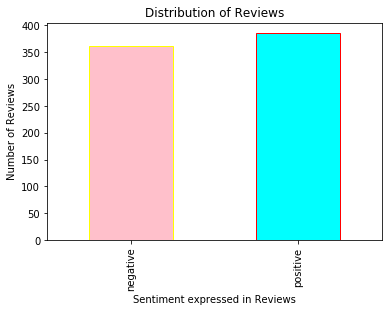

In [9]:
#sns.countplot(review_df['score'])
review_df['sentiment'].value_counts().sort_index().plot(kind='bar', color=['pink','cyan'], edgecolor=['yellow','red'], width=0.5)
plt.xlabel('Sentiment expressed in Reviews')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews')


The Dataset labels seems to be balanced, there will be no need for any under/over sampling

## Cleaning Dataset

### Removing Punctuations, Special characters, and Numbers 

In [10]:
review_df['clean_review'] = review_df['review_text'].str.replace("[^a-zA-Z#]", " ").str.lower()

In [11]:
review_df.head()

,review_text,score,sentiment,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,negative,a very very very slow moving aimless movie ...
1,Not sure who was more lost - the flat characte...,0,negative,not sure who was more lost the flat characte...
2,Attempting artiness with black & white and cle...,0,negative,attempting artiness with black white and cle...
3,Very little music or anything to speak of.,0,negative,very little music or anything to speak of
4,The best scene in the movie was when Gerardo i...,1,positive,the best scene in the movie was when gerardo i...


### Remove the smaller words

I decided to get rid of word less than or equal to 3 letters words simply becuase they are of little value

In [12]:
review_df['clean_review'] = review_df['clean_review'].apply(lambda x:' '.join([y for y in x.split() if len(y)>3]))

In [13]:
review_df.head()

,review_text,score,sentiment,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,negative,very very very slow moving aimless movie about...
1,Not sure who was more lost - the flat characte...,0,negative,sure more lost flat characters audience nearly...
2,Attempting artiness with black & white and cle...,0,negative,attempting artiness with black white clever ca...
3,Very little music or anything to speak of.,0,negative,very little music anything speak
4,The best scene in the movie was when Gerardo i...,1,positive,best scene movie when gerardo trying find song...


In [14]:
#review_df['clean_review'].value_counts()

In [15]:
# unique = len(review_df.clean_review.unique())

# print("Number of unique review: {}".format(unique))

### Tokenisation of Review Text

Tokenization is the process of splitting or segmenting sentences into their constituent words. A sentence is a collection of words, and with tokenization we essentially split a sentence into a list of words or tokens.

In [16]:
tokenised_review = review_df['clean_review'].apply(lambda x: x.split())

tokenised_review.head()

0    [very, very, very, slow, moving, aimless, movi...
1    [sure, more, lost, flat, characters, audience,...
2    [attempting, artiness, with, black, white, cle...
3               [very, little, music, anything, speak]
4    [best, scene, movie, when, gerardo, trying, fi...
Name: clean_review, dtype: object

### Stemming
Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes (“ing”, “ly”, “es”, “s” etc) that can be found in an inflected word. For example, For example – “move”, “moving”, “moved”, “moves”  are the different variations of the word – “move”.

We will be using stem(word) method of nltk.stem.porter.PorterStemmer instance
    Strip affixes from the token and return the stem.

In [17]:

review_stemmer = PorterStemmer(mode='NLTK_EXTENSIONS')

tokenised_review = tokenised_review.apply(lambda x: [review_stemmer.stem(j) for j in x])

tokenised_review.head()

0    [veri, veri, veri, slow, move, aimless, movi, ...
1    [sure, more, lost, flat, charact, audienc, nea...
2    [attempt, arti, with, black, white, clever, ca...
3                   [veri, littl, music, anyth, speak]
4    [best, scene, movi, when, gerardo, tri, find, ...
Name: clean_review, dtype: object

In [18]:
# Join the word or token back

for i in range(len(tokenised_review)):
    tokenised_review[i] = ' '.join(tokenised_review[i])

review_df['clean_review'] = tokenised_review

review_df.head()


,review_text,score,sentiment,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,negative,veri veri veri slow move aimless movi about di...
1,Not sure who was more lost - the flat characte...,0,negative,sure more lost flat charact audienc nearli hal...
2,Attempting artiness with black & white and cle...,0,negative,attempt arti with black white clever camera an...
3,Very little music or anything to speak of.,0,negative,veri littl music anyth speak
4,The best scene in the movie was when Gerardo i...,1,positive,best scene movi when gerardo tri find song tha...


# Visualisation of Review

We will be visualising the review using wordcloud module. The module visualised the most frequent words in large size and the less frequent words in smaller sizes.

#### Objective:
    1. To know the most frequent words
    2. Words that contributed to Negative stress
    3. Words that contributed to Positive stress
    
    




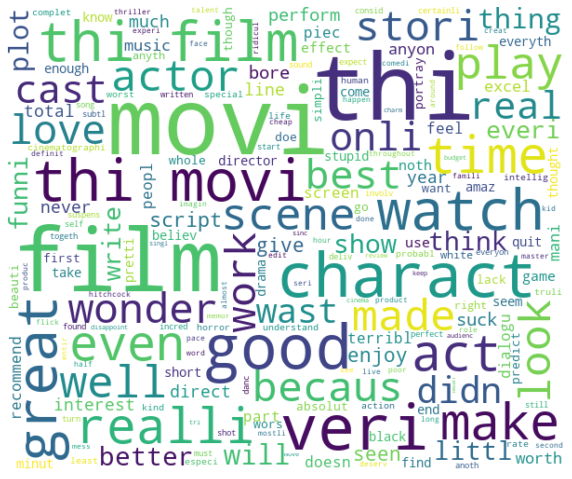

In [19]:
words = ''.join([text for text in review_df['clean_review']])

cloud_word = WordCloud(width= 600, height = 500, random_state = 31, max_font_size = 100, background_color='white').generate(words)

plt.figure(figsize = (10, 15))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With film, movie, good, character being the most frequent ones.  Similarly, we will plot the word cloud for the Positive and Negative score.

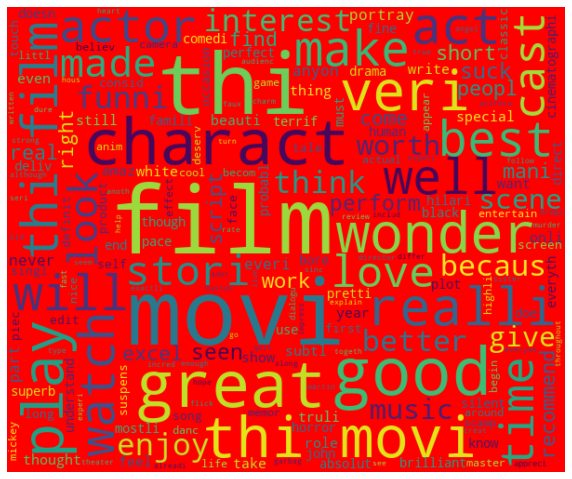

In [20]:
positive_words = ''.join([text for text in review_df['clean_review'][review_df['score']==1]])

cloud_word = WordCloud(width= 600, height = 500, max_font_size = 100, background_color='red').generate(positive_words)

plt.figure(figsize = (10, 25))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

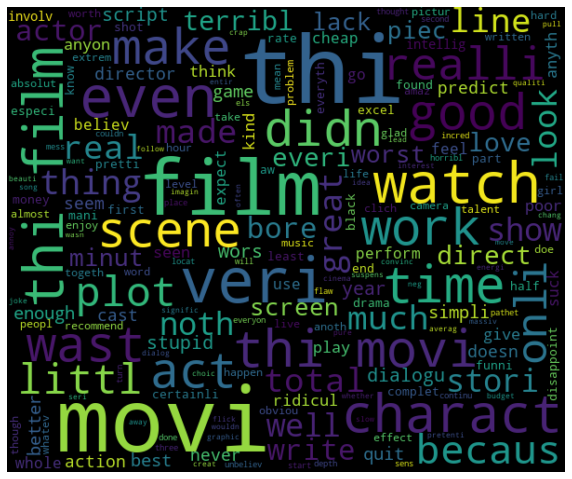

In [21]:
negative_words = ''.join([text for text in review_df['clean_review'][review_df['score']==0]])

cloud_word = WordCloud(width= 600, height = 500, max_font_size = 100, background_color='black').generate(negative_words)

plt.figure(figsize = (10, 15))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

Despite the fact that it was saturated by common words like film, watch, very etc; there are nagative words like bore, suck, redicule etc.

## Extracting Features from Cleaned Reviews

Since machine learning can not take a sentence as an argument, it is of necessary to convert it to features. We will be using
Bag-of-Words, TF-IDF

### Bag-of-Words
    Documents are described by word occurrences while completely ignoring the relative position information of the words in the document. Bag-of-Words features can be easily created using sklearn’s CountVectorizer function.
    
### TF-IDF
    In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.
    

In [22]:
x = review_df['clean_review']
y = review_df["score"]

### Splitting of Dataset into Train and Test sets

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

print('Train set Shape:\t{}\nTest set Shape:\t\t{}'.format(x_train.shape, y_test.shape))

Train set Shape:	(598,)
Test set Shape:		(150,)


### Applying CountVectorizer with the Naive Bayes Model

In [24]:
# Instantiate CountVectorizer
countVectorizer = CountVectorizer()

# Fit and transform the data
countVectorizer_Xtrain = countVectorizer.fit_transform(x_train).toarray()
countVectorizer_Xtest = countVectorizer.transform(x_test).toarray()

words = countVectorizer.get_feature_names()
print('word length:', len(words))
pd.DataFrame(countVectorizer_Xtrain, columns=words).head()

word length: 2103


,aailiyah,abandon,abil,about,abov,abroad,absolut,abstrus,abysm,academi,...,yelp,young,younger,your,yourself,youth,youtub,zillion,zombi,zombiez
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Define function to run model

def test_model(model, vectorizer_Xtrain, y_train, vectorizer_Xtest, y_test):
    
    prediction = model.fit(vectorizer_Xtrain, y_train).predict(vectorizer_Xtest)
    
    print(classification_report(y_test, prediction, target_names=['No', 'Yes']))
    print("Confusion Matrix\n {}\n".format(confusion_matrix(y_test, prediction, normalize=None)))

In [26]:
# Modelling with MultinomialNB
print("\nModelling with MultinomialNB with Cross Validation and CountVectorizer")
test_model(GaussianNB(), countVectorizer_Xtrain, y_train, countVectorizer_Xtest, y_test)




Modelling with MultinomialNB with Cross Validation and CountVectorizer
              precision    recall  f1-score   support

          No       0.59      0.88      0.71        76
         Yes       0.75      0.36      0.49        74

    accuracy                           0.63       150
   macro avg       0.67      0.62      0.60       150
weighted avg       0.67      0.63      0.60       150

Confusion Matrix
 [[67  9]
 [47 27]]



### Applying TF-IDF (Term Frequency, Inverse Document Frequency) with the Naive Bayes Model

In [27]:
# Intantiate TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 1))

# Fit and Transform x_train data
tfidf_Xtrain = tfidf.fit_transform(x_train).toarray() 
tfidf_Xtest = tfidf.transform(x_test).toarray()

words_ = tfidf.get_feature_names()
print('word length:', len(words_))
pd.DataFrame(tfidf_Xtest, columns=words_).head()

word length: 2103


,aailiyah,abandon,abil,about,abov,abroad,absolut,abstrus,abysm,academi,...,yelp,young,younger,your,yourself,youth,youtub,zillion,zombi,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Modelling with MultinomialNB
print("\nModelling with MultinomialNB with Cross Validation and TFIDF\n")
mnb = test_model(GaussianNB(), tfidf_Xtrain, y_train, tfidf_Xtest, y_test)



Modelling with MultinomialNB with Cross Validation and TFIDF

              precision    recall  f1-score   support

          No       0.63      0.76      0.69        76
         Yes       0.69      0.54      0.61        74

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150

Confusion Matrix
 [[58 18]
 [34 40]]



### Cross Validation Application

We apply cross validation to both countvectoriser and TFIDF separately. Also, F1-score and Accuracy score was used for the metric.

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle = False, random_state=None)

# X is the feature set and y is the target
for train_index, test_index in skf.split(x, y):
    
    X_train_CV, X_test_CV = x[train_index], x[test_index]
    y_train_CV, y_test_CV = y[train_index], y[test_index]
    #print("Train:", train_index, "\n", "Test:", test_index)
    
# Instantiate CountVectorizer
vect = CountVectorizer()

# Fit and transform the data
vect_Xtrain_Cv = vect.fit_transform(X_train_CV)
vect_Xtrain_Cv = vect_Xtrain_Cv.toarray()

vect_Xtest_CV = vect.transform(X_test_CV)
vect_Xtest_CV =  vect_Xtest_CV.toarray()

y_pred = GaussianNB().fit(vect_Xtrain_Cv, y_train_CV).predict(vect_Xtest_CV)
print(f'F1-Score:   {f1_score(y_pred, y_test_CV)*100:.2f}%')
print(f'Accuracy-Score:   {accuracy_score(y_pred, y_test_CV)*100:.2f}%')

F1-Score:   70.24%
Accuracy-Score:   66.44%


###### Cross Validation with TFIDF

In [30]:
   
tfidf = TfidfVectorizer(ngram_range=(1, 1))

# Fit and Transform x_train data
tfidf_Xtrain_CV = tfidf.fit_transform(X_train_CV)
tfidf_Xtrain_CV = tfidf_Xtrain_CV.toarray() 

tfidf_Xtest_CV = tfidf.transform(X_test_CV)
tfidf_Xtest_CV = tfidf_Xtest_CV.toarray()

y_pred = GaussianNB().fit(tfidf_Xtrain_CV, y_train_CV).predict(tfidf_Xtest_CV)

print(f'F1-Score:   {f1_score(y_pred, y_test_CV)*100:.2f}%')
print(f'Accuracy-Score:   {accuracy_score(y_pred, y_test_CV)*100:.2f}%')

F1-Score:   69.62%
Accuracy-Score:   67.79%
